In [1]:
from simulate import HawkesProcess, PriceProcess
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd

In [14]:
class MultiHawkesProcess:
    # Implements Algo 1 from https://www.math.fsu.edu/~ychen/research/multiHawkes.pdf
    def __init__(self, mus, alphas, betas) -> None:
        self.M = len(mus) # number of dimensions
        self.mus = mus
        self.alphas = alphas
        self.betas = betas

    def get_rate(self, m, events, t):
        res = self.mus[m]
        for n in range(self.M):
            for t_i in events[n]:
                res += self.alphas[m][n] * np.exp(-self.betas[m][n] * (t - t_i))
        return res
    
    def get_rate_sum(self, events, t):
        return sum([self.get_rate(m, events, t) for m in range(self.M)])

    def simulate(self, T):
        s = 0
        events = [[] for i in range(self.M)]
        # events = np.empty((self.M, 0))
        while s < T:
            lambda_bar = self.get_rate_sum(events, s)
            e = np.random.exponential(1/lambda_bar)
            s += e
            D = np.random.rand()
            ratio = self.get_rate_sum(events, s) / lambda_bar
            if D < ratio:
                k = 0
                new_sum = self.get_rate(k, events, s)
                while D*lambda_bar > new_sum:
                    k += 1
                    new_sum += self.get_rate(k, events, s)
                events[k].append(s)
                # events[k] = np.append(events[k], s)

        return events
    
mus = [0.1, 0.2]
alphas = [[0.1, 0.2], [0.2, 0.1]]
betas = [[0.1, 0.2], [0.2, 0.1]]

hawkes = MultiHawkesProcess(mus, alphas, betas)
T = 10
events = hawkes.simulate(T)

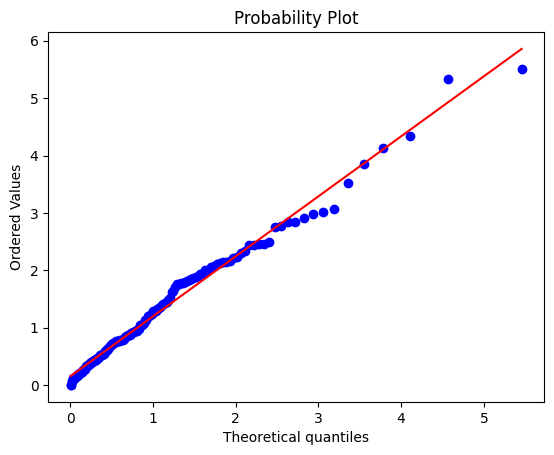

In [156]:
mu, alpha, beta = 1.6, 2.4, 11
hwk = HawkesProcess(mu, alpha, beta)
T = 100
events = hwk.simulate(T)

hwk.plot_QQ(events)

In [159]:
class PriceProcess:

    """We simulate the price as X(t)=N_+(t)-N_-(t) where N_+ (resp. N_-) is a Hawkes process with parameters (mu, alpha, beta)
    representing positive (resp. negative) price jumps."""

    def __init__(self, mu, alpha, beta):
        self.mu = mu
        self.alpha = alpha
        self.beta = beta

    def simulate(self, T):
        hawkes = HawkesProcess(self.mu, self.alpha, self.beta)
        pos_events = hawkes.simulate(T)
        neg_events = hawkes.simulate(T)
                # set dtype to datetime64[ns]
        pos_events = pd.to_datetime(pos_events, unit='s')
        neg_events = pd.to_datetime(neg_events, unit='s')
        # create time series with index = time and value = price
        index = np.concatenate((pos_events, neg_events))
        time_series = pd.Series(index=index)
        time_series.loc[pos_events] = 1
        time_series.loc[neg_events] = -1
        time_series = time_series.sort_index()
        time_series = time_series.cumsum()
        return time_series

In [134]:
T  = ts.index[-1] - ts.index[0]
x = ts.resample('1s').first().ffill()
c = (x.diff()**2).sum() / T.total_seconds()
print(f'c = {c}')

c = 9.509528460204928


In [136]:
# df = pd.read_csv("../../datasets/TrueFX/EURUSD-2024-02/EURUSD-2024-02.csv", header=None)
# df.columns = ['Pair', 'TimeStamp', 'Bid', 'Ask']
# df = df[['TimeStamp', 'Bid', 'Ask']]
# df['TimeStamp'] = pd.to_datetime(df['TimeStamp']) - pd.Timedelta(hours=5) # turn GMT to EST time
# df['Date'] = df['TimeStamp'].dt.date

In [160]:
# chosen_date = pd.to_datetime('2024-02-01').date()
# sub_df = df[df['Date'] == chosen_date]
# sub_df
# copy_sub_df = sub_df.copy()

<Axes: >

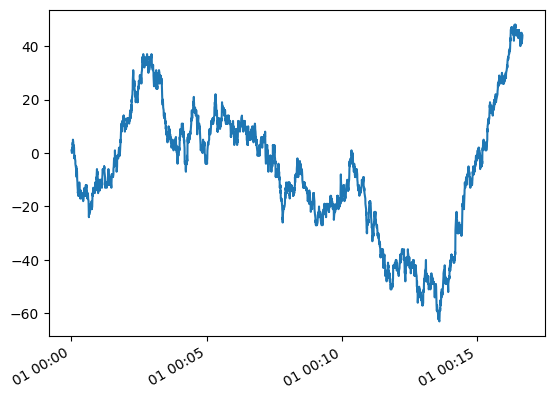

In [163]:
pp = PriceProcess(mu, alpha, beta)
T = 100
ts = pp.simulate(T)

ts.plot()

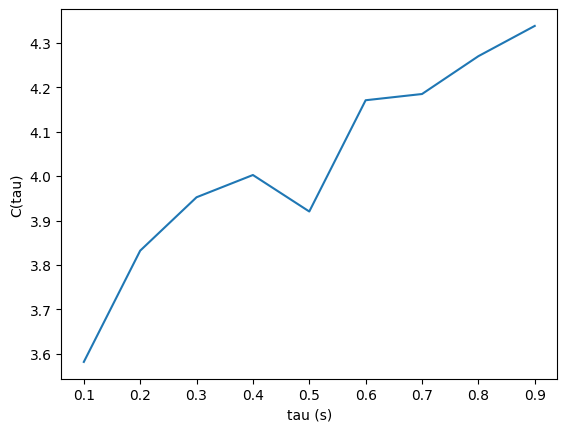

In [164]:
def C(ts: pd.Series, tau: pd.Timedelta):
    # resample the series to have a constant time step
    T = ts.index[-1] - ts.index[0]
    ts = ts.resample(rule=tau).first().ffill()
    qv = ((ts.diff())**2).sum() / T.total_seconds()
    return qv

taus = pd.to_timedelta(range(100,1000,100), unit='ms')

C_values = [C(ts, tau) for tau in taus]
plt.plot(taus.total_seconds(), C_values)
plt.xlabel('tau (s)')
plt.ylabel('C(tau)')
plt.show()